# Import Packages

In [ ]:
import time
from collections import deque
from multiprocessing import Pool, Process
from xml.etree import ElementTree as et

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import scipy
from alive_progress import alive_bar
from dm_control import composer, mjcf, mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums, mjlib
from dm_control.utils import inverse_kinematics as ik
from IPython.display import HTML
from PIL import Image
from scipy.special import gamma
from sklearn.decomposition import PCA


%env MUJOCO_GL=egl
%matplotlib widget

# Define Utility Methods and Constants

In [ ]:
# Rendering parameters
dpi = 100
framerate = 60  # (Hz)
width, height = 1920, 1080

# IK solver parameters
_MAX_STEPS = 100
_TOL = 1e-12
_TIME_STEP = 2e-3

# Scene XML
robot_xml = "models/panda_nohand.xml"
scene_xml = "models/scene.xml"


def display_video(frames, framerate=framerate, figsize=None):
    height, width, _ = frames[0].shape
    orig_backend = matplotlib.get_backend()
    matplotlib.use("Agg")  # Switch to headless 'Agg' to inhibit figure rendering.
    if figsize is None:
        figsize = (width / dpi, height / dpi)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect("equal")
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]

    interval = 1000 / framerate
    anim = animation.FuncAnimation(
        fig=fig, func=update, frames=frames, interval=interval, blit=True, repeat=False
    )
    return HTML(anim.to_html5_video())


def J_zero(physics, site_name):
    phys = mujoco.Physics.from_model(physics.model)
    jac_pos = np.zeros((3, phys.model.nv))
    jac_rot = np.zeros((3, phys.model.nv))
    mjlib.mj_jacSite(
        phys.model.ptr,
        phys.data.ptr,
        jac_pos,
        jac_rot,
        phys.model.name2id(site_name, "site"),
    )

    return np.vstack((jac_pos, jac_rot))

# Update The Scene XML File
* [Mujoco XML Reference](https://mujoco.readthedocs.io/en/latest/XMLreference.html?highlight=site#body-site)
* [The ElementTree XML API](https://docs.python.org/3/library/xml.etree.elementtree.html)

## Tactile Sensor

1. Sensor Pad 
* for visual only

2. Collision Balls (single or dual layer)
* _M: (x-count, y-count)
* geom_type: [sphere, capsule, ellipsoid, cylinder, box], “sphere”
* dx: the distance between each site
* offset: uniform distance to shift all sites

3. Slide Joints
* connect the balls to the pad
* joint positions serve as sensory values
* small time constant

4. Tendons to Connect Balls
* planar spring connection
* creates contact-force distribution

In [ ]:
# Define 3D arrays of balls connected with sliders
_M = (20, 20)
radius = 4e-4
mass = 1e-12 / np.prod(_M)
dx = (3e-2 - 2 * radius) / (_M[0] - 1)
offset = dx * (_M[0] - 1) / 2.0
geom_type = "sphere"

tree = et.parse(robot_xml)
root = tree.getroot()
for body in root.findall(".//body"):
    if body.get("name") == "sensor_pad":
        sensor_pad = body

# If balls and tendons are already defined, remove them first
if sensor_pad.find("body") is not None:
    for body in sensor_pad.findall("body"):
        sensor_pad.remove(body)
tendon = root.find("tendon")
if tendon is not None:
    for spatial in tendon.findall("spatial"):
        tendon.remove(spatial)


def create_linked_ball(sid, pos, euler, springdamper=(1e-2, 1)):
    # Create base ball
    elem = et.Element("body")
    elem.set("name", "taxel" + str(sid))
    elem.set("pos", "{:.6f} {:.6f} {:.6f}".format(pos[0], pos[1], pos[2]))
    elem.set("euler", euler)
    # Inertia
    inertia = et.Element("inertial")
    inertia.set("mass", str(mass))
    inertia.set("pos", "0 0 0")
    inertia.set("fullinertia", "1e-6 1e-6 1e-6 0 0 0")
    # Joint
    joint = et.Element("joint")
    joint.set("type", "slide")
    joint.set("axis", "0 0 1")
    joint.set("springdamper", "{} {}".format(springdamper[0], springdamper[1]))
    joint.set("frictionloss", "1e-2")
    # Geom
    geom = et.Element("geom")
    geom.set("name", "ball" + str(sid))
    geom.set("type", geom_type)
    geom.set("size", str(radius))
    geom.set("class", "collision")
    # Site
    site = et.Element("site")
    site.set("name", "tendon_site" + str(sid))
    site.set("type", "sphere")
    site.set("size", "1e-4")
    site.set("group", "1")
    # Add to dynamic tree
    elem.append(inertia)
    elem.append(joint)
    elem.append(geom)
    elem.append(site)
    return elem


def create_tendon(tid, site_names):
    spatial = et.Element("spatial")
    spatial.set("name", "tendom" + str(tid))
    spatial.set("width", "2e-4")
    spatial.set("limited", "true")
    spatial.set("range", "0 {:.6f}".format(4 * dx))
    spatial.set("frictionloss", "1e-2")
    spatial.set("stiffness", "1e-2")
    spatial.set("damping", "0.4")
    for sn in site_names:
        site = et.Element("site")
        site.set("site", sn)
        spatial.append(site)
    return spatial


# Define balls with sliders and touch sensors
sid = 0
for i in range(_M[0]):
    for j in range(_M[1]):
        sid += 1
        parent = create_linked_ball(
            sid, (dx * i - offset, dx * j - offset, 1e-3), "0 0 0", (2e-3, 0.9)
        )
        # child = create_linked_ball(sid + _M[0]*_M[1], (0, 0, 2e-3), '0 0 0', (1e-3, 0.9))
        # parent.append(child)
        sensor_pad.append(parent)

# Define tendons
tid = 0
for m in range(_M[0]):
    for n in range(_M[1]):
        tid += 1
        if n != _M[0] - 1:
            site_ids = [n + 1 + k + m * _M[0] for k in range(2)]
            spatial = create_tendon(tid, ["tendon_site" + str(i) for i in site_ids])
            tendon.append(spatial)
        if m != _M[0] - 1:
            tid += 1
            site_ids = [n + 1 + (m + k) * _M[0] for k in range(2)]
            spatial = create_tendon(tid, ["tendon_site" + str(i) for i in site_ids])
            tendon.append(spatial)


tree.write(robot_xml)  # Save robot

## Setup `rotator_scene.xml` Key Frames
* Initial poses

In [ ]:
# Modify the keyframe home key qpos
njoints = np.prod(_M) + 10
tree = et.parse(scene_xml)
root = tree.getroot()
key = root.find(".//keyframe/key")
qpos_value = "0 0 0 -1.570796 0 1.570796 0.785398 0 0 0"
key.attrib["ctrl"] = qpos_value
if njoints > 10:
    qpos_value += " " + " ".join(["0" for i in range(njoints - 10)])
key.attrib["qpos"] = qpos_value
tree.write(scene_xml)

# Robotic Simulation for Tactile Encoding Test

* Contact the Objects and Gain Tactile Feedback on Multiple Edge Types
1. curvy
2. round
3. plateau

In [ ]:
# Load scene
physics = mujoco.Physics.from_xml_path(scene_xml)

# Define simulation variables
site_name = "attachment_site"
control_site = physics.data.site(name=site_name)
reach_sites = ["reach_site" + str(i + 1) for i in range(3)]
joint_names = ["joint{}".format(i + 1) for i in range(7)]


def wrap2pi(xs):
    return np.mod(xs, 2 * np.pi)


def reach_test(target_name, duration=5.0, rendered=False):
    omega = np.array([1, 1, 1]) * 2 * np.pi / duration  # Rotator angular velocities
    target_site = physics.data.site(name=target_name)
    video = []
    stream = []
    orientations = []

    # Simulate, saving video frames
    physics.reset(0)
    physics.step()
    ctrl = np.zeros(10)
    quat = np.zeros(4)
    mjlib.mju_mat2Quat(quat, control_site.xmat)
    with alive_bar(
        int(duration / _TIME_STEP), force_tty=True, title="Simulating"
    ) as bar:
        while physics.data.time < duration:
            target_pos = target_site.xpos
            if physics.data.time < duration * 0.1:
                target_pos[2] += 0.02
            # Compute the inverse kinematics
            if np.linalg.norm(control_site.xpos - target_pos) > _TOL:
                result = ik.qpos_from_site_pose(
                    physics,
                    site_name,
                    target_pos=target_site.xpos,
                    target_quat=quat,
                    joint_names=joint_names,
                    tol=_TOL,
                    max_steps=_MAX_STEPS,
                    inplace=False,
                )
                ctrl[:7] = result.qpos[:7]
            ctrl[-3:] = wrap2pi(omega * physics.data.time)
            physics.set_control(ctrl)
            physics.step()

            # Save contact pressure > 0
            if physics.data.time >= 2.0:
                pressure = physics.data.qpos[7:-3].copy().reshape(_M)
                stream.append(np.expand_dims(pressure, -1))
                rotator_ctrl = physics.data.qpos[-3:].copy()
                orientations.append(rotator_ctrl)

            # Save video frames and sensor data
            if rendered and len(video) < physics.data.time * framerate:
                pixels = physics.render(
                    camera_id="prospective", width=width, height=height
                )
                video.append(pixels.copy())

            # Update progress
            bar()
    return video, stream, np.array(orientations)


# Solo for testing XML
physics.reset(0)
pixels = physics.render(camera_id="prospective", width=width, height=height)
Image.fromarray(pixels)

## Curvy Edge

In [ ]:
video1, stream1, oris1 = reach_test(reach_sites[0])
#display_video(video1)
#display_video(stream1, 30, (5, 5))

## Round Edge

In [ ]:
video2, stream2, oris2 = reach_test(reach_sites[1])
#display_video(video2)
#display_video(stream2, 30, (5, 5))

## Plateau Edge

In [ ]:
video3, stream3, oris3 = reach_test(reach_sites[2])
#display_video(video3)
#display_video(stream3, 30, (5, 5))

# Save Edge Data Streams

In [ ]:
# Save stream data for analysis
np.savez_compressed(
    "touch_stream",
    curvy_stream=stream1,
    round_stream=stream2,
    plateau_stream=stream3,
    curvy_oris=oris1[:,0],
    round_oris=oris2[:,1],
    plateau_oris=oris3[:,2]
)

# Edge Orientation and Width Detection
## Generalized Gaussian Encoding for Tactile Signals
* F. Pascal, L. Bombrun, J. -Y. Tourneret and Y. Berthoumieu, "Parameter Estimation For Multivariate Generalized Gaussian Distributions," in IEEE Transactions on Signal Processing, vol. 61, no. 23, pp. 5960-5971, Dec.1, 2013, doi: 10.1109/TSP.2013.2282909.

In [ ]:
# Load dataset
streams = np.load("touch_stream.npz")
[sCurvy, sRound, sPlateau, oCurvy, oRound, oPlateau] = [np.squeeze(streams[file]) for file in streams.files]
frames = np.min([len(sCurvy), len(sRound), len(sPlateau)])


def compute_vec(data):
    pca = PCA(n_components=2)
    mat = -np.squeeze(data)
    mat = (mat - np.min(mat)) / np.std(mat)
    x, y = np.where(mat > np.mean(mat))
    X = np.squeeze(np.dstack((x, y)))
    x0, y0 = np.ceil(np.mean(X, axis=0))
    pca.fit(X)
    V = pca.components_
    a = np.sqrt(pca.singular_values_)
    V[0, :] *= a[1]  # Edge width
    V[1, :] *= 1.7 * a[0]  # Edge direction
    origin = np.array([[y0, y0], [x0, x0]])
    W = np.vstack((V[0, :], -V[0, :]))
    V = np.vstack((V[1, :], -V[1, :]))
    m = 1
    beta = a[1]
    mu = np.array([x0, y0])
    M = pca.get_covariance()
    mggd = M
    return origin, V, W


# Visualize data stream
def visualize(dataset, title):
    orig_backend = matplotlib.get_backend()
    matplotlib.use("Agg")  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_title(title)
    im = ax.imshow(dataset[0])
    origin, V, W = compute_vec(dataset[0])

    quiverV = ax.quiver(*origin, V[:, 0], V[:, 1], color=["r"], scale=20)
    quiverW = ax.quiver(
        *origin,
        W[:, 0],
        W[:, 1],
        color=["b"],
        scale=20,
        headaxislength=0,
        headwidth=0,
        headlength=0
    )

    def update(frame):
        im.set_data(dataset[frame])
        origin, V, W = compute_vec(dataset[frame])
        quiverV.set_offsets(origin.T)
        quiverV.set_UVC(V[:, 0], V[:, 1])
        quiverW.set_offsets(origin.T)
        quiverW.set_UVC(W[:, 0], W[:, 1])
        return [im, quiverV, quiverW]

    anim = animation.FuncAnimation(
        fig=fig, func=update, frames=frames, interval=30, blit=True, repeat=False
    )
    return HTML(anim.to_html5_video())


#visualize(sCurvy, 'Curvy Edge')
#visualize(sRound, 'Round Edge')
#visualize(sPlateau, "Plateu Edge")

## Test TacNet - tactile encoding spiking network

WARNING    Cannot check whether the indices to record from are valid. This can happen in standalone mode when recording from synapses that have been created with a connection pattern. You can avoid this situation by using synaptic indices in the connect call. [brian2.monitors.statemonitor.cannot_check_statemonitor_indices]


Starting simulation at t=0 s for duration 1.502 s
1.502 s (100%) simulated in < 1s


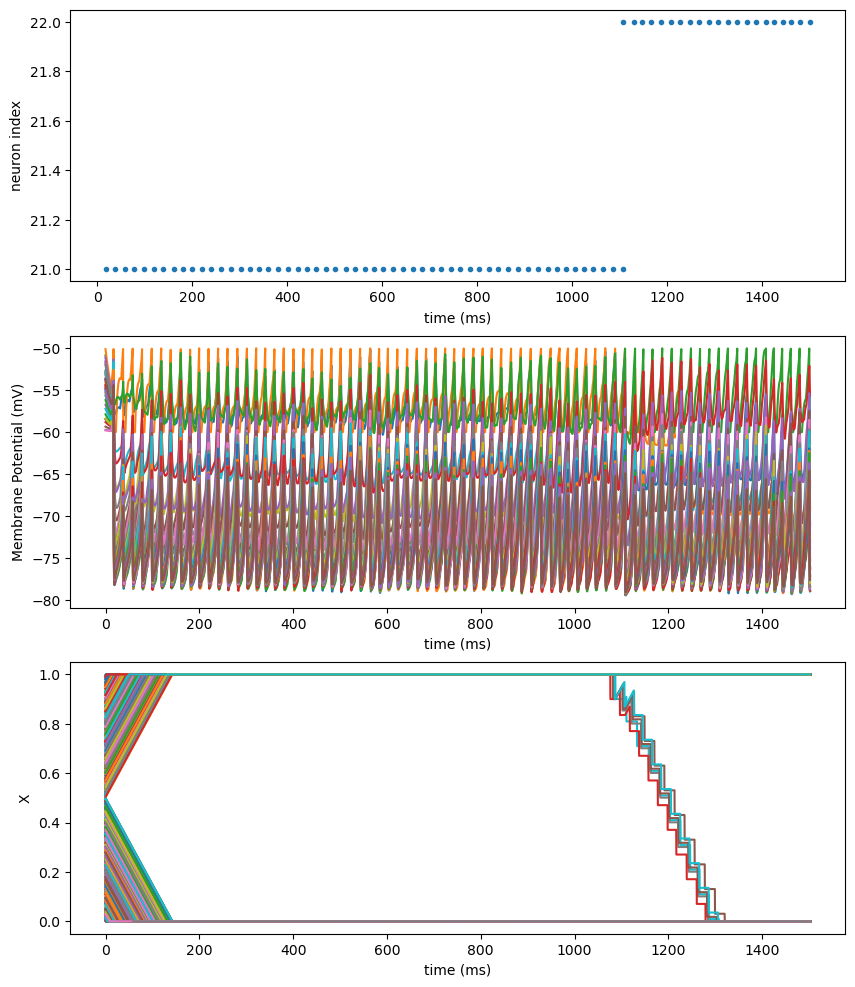

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shutil

from brian2 import *
from brian2tools import brian_plot, plot_state

from TacNet import TacNet


set_device('cpp_standalone')

if 'initiated' in locals():
    device.reinit()
    device.activate()
else:
    initiated = True

# Load 
streams = np.load("touch_stream.npz")
[sCurvy, sRound, sPlateau, oCurvy, oRound, oPlateau] = [
    np.squeeze(streams[file]) for file in streams.files]
frames = np.min([len(sCurvy), len(sRound), len(sPlateau)])

dt = 1*ms
inputs = sPlateau.reshape(sPlateau.shape[0], -1)
inputs -= inputs.min()
I = TimedArray(inputs/inputs.max()*200*pA, dt=dt)
duration = I.values.shape[0]*dt

model = TacNet([400, 20, 36])
mons = model.run(I, duration)

mon0 = mons['SpikeMonitor_L3']
mon1 = mons['StateMonitor_L3']
mon2 = mons['StateMonitor_Syn23']
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
brian_plot(mon0, axes=axs[0])
plot_state(mon1.t, mon1.v.T, axes=axs[1], var_name='Membrane Potential')
plot_state(mon2.t, mon2.X.T, axes=axs[2], var_name='X')
plt.show()